In [1]:
from __future__ import division 
import h5py as h5

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [114]:
from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams
rc('font', family='serif')



matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
fs = 30

loc_images = '/Users/fbro0003/Documents/git/popsynth/Papers/BroekgaardenEtAl/BHNS_predictions/images/' 



In [8]:

def obtainDataSTROOPWAFEL(param, pathToDirectory):
    """returns for STROOPWAFEL (AIS) simulation the data of wanted variable
    combines the data from AIS_exploratory and AIS_sampling 
    
    param = [xparam, fxparam] ,  are the name of the variable and hdf5 keyname where it is in
    e.g. param = ['M1', 'doubleCompactObjects'] (see also: print(list(f.keys())))
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """ 

    xparam, fxparam = param

    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'  
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    

    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref)
      
        
    ##### get parameter from two directories and combine them ############
    xvaluesAISexpl          = fAISexpl[fxparam][xparam][...].squeeze()
    xvaluesAISref           = fAISref[fxparam][xparam][...].squeeze()

    xvalues = np.concatenate((xvaluesAISexpl, xvaluesAISref))

    return   xvalues



def maskTargetDCOsSTROOPWAFEL(fxparam, DCOtype, boolDCOmask, pathToDirectory):
    """returns mask of DCOs of interest
    fxparam  is hdf5 keyname of file where variable for which you want to mask DCOs is in 
    DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """
    
    Hubble, RLOF, Pessimistic = boolDCOmask
    
    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'   
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    
    
    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref) 
    
    fDCOAISexpl = fAISexpl['doubleCompactObjects']
    fDCOAISref  = fAISref['doubleCompactObjects']
    
    
    
    # mask binaries of given DCO type
    if DCOtype == 'BNS':
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 13) & (fDCOAISexpl['stellarType2'][...] == 13))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 13) & (fDCOAISref['stellarType2'][...] == 13))

    elif (DCOtype == 'BHNS') | (DCOtype == 'NSBH'):
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 13) & (fDCOAISexpl['stellarType2'][...] == 14)) | \
            ((fDCOAISexpl['stellarType1'][...] == 14) & (fDCOAISexpl['stellarType2'][...] == 13) )          
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 13) & (fDCOAISref['stellarType2'][...] == 14)) | \
            ((fDCOAISref['stellarType1'][...] == 14) & (fDCOAISref['stellarType2'][...] == 13) )
    elif DCOtype == 'BBH':
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 14) & (fDCOAISexpl['stellarType2'][...] == 14))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 14) & (fDCOAISref['stellarType2'][...] == 14))

    elif (DCOtype == 'all') | (DCOtype == 'ALL') :
        mask0AISexpl = ((fDCOAISexpl['stellarType1'][...] == 14) | (fDCOAISexpl['stellarType1'][...] == 13))
        mask0AISref = ((fDCOAISref['stellarType1'][...] == 14) | (fDCOAISref['stellarType1'][...] == 13))
    else:
        print('error: DCO type not known')
        
    # Hubble mask
    if Hubble:
        mask1AISexpl = (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==True) 
        mask1AISref = (fDCOAISref['mergesInHubbleTimeFlag'][...]==True) 
    elif not Hubble:
        mask1AISexpl = (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==True) |  (fDCOAISexpl['mergesInHubbleTimeFlag'][...]==False) 
        mask1AISref = (fDCOAISref['mergesInHubbleTimeFlag'][...]==True) |  (fDCOAISref['mergesInHubbleTimeFlag'][...]==False) 
       
    # RLOF mask
    if RLOF:
        mask2AISexpl = (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==False)
        mask2AISref = (fDCOAISref['RLOFSecondaryAfterCEE'][...]==False)
    elif not RLOF:
        mask2AISexpl = (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==False) | (fDCOAISexpl['RLOFSecondaryAfterCEE'][...]==True)
        mask2AISref = (fDCOAISref['RLOFSecondaryAfterCEE'][...]==False) |  (fDCOAISref['RLOFSecondaryAfterCEE'][...]==True)

    # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
    if Pessimistic:
        mask3AISexpl = np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 1)
        mask3AISref  = np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 1)
    elif not Pessimistic:
        mask3AISexpl = np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 1) + \
        np.logical_not(fDCOAISexpl["optimisticCEFlag"][...] == 0)   
        mask3AISref = np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 1) + \
        np.logical_not(fDCOAISref["optimisticCEFlag"][...] == 0) 
    
    # combine the different masks and the exploratory and refinement masks
    combinedMaskAISexpl = mask0AISexpl * mask1AISexpl * mask2AISexpl * mask3AISexpl
    combinedMaskAISref = mask0AISref * mask1AISref * mask2AISref * mask3AISref  
    combinedmask = np.concatenate((combinedMaskAISexpl, combinedMaskAISref))

    if fxparam != 'doubleCompactObjects': # we need to get the mask from comparing the seeds
        
        # you might need to change 'randomSeed if that's not the name of the seed param in the file
        seedsOfIntererstAISexpl = fDCOAISexpl['seed'][combinedMaskAISexpl]
        seedsAISexpl = fAISexpl[fxparam]['randomSeed'][...].squeeze()
        boolsAISexpl = np.in1d(seedsAISexpl, seedsOfIntererstAISexpl)
       
        seedsOfIntererstAISref = fDCOAISref['seed'][combinedMaskAISref]
        seedsAISref = fAISref[fxparam]['randomSeed'][...].squeeze()
        boolsAISref = np.in1d(seedsAISref, seedsOfIntererstAISref)      
    
        combinedmask = np.concatenate((boolsAISexpl, boolsAISref))
          
    return combinedmask.squeeze()


def obtainWeightsSTROOPWAFEL(pathToDirectory):
    """returns weights for all DCOs and all systems for STROOPWAFEL
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are 
    """
    
    pathAISexpl = pathToDirectory +'/AIS_exploratory/COMPASOutput.h5'   # '/home/floor/Data_Thesis/bdMC/Z0_002'
    pathAISref  = pathToDirectory +'/AIS_sampling/COMPASOutput.h5'    # '/home/floor/Data_Thesis/bdMC/Z0_002'

    fAISexpl = h5.File(pathAISexpl)
    fAISref = h5.File(pathAISref)    


    ##### get the DCO and all system weights  ############
    DCOweightsAISexpl          = fAISexpl['doubleCompactObjectsWeights']['weight'][...].squeeze()
    DCOweightsAISref           = fAISref['doubleCompactObjectsWeights']['weight'][...].squeeze()
    
    DCOweights = np.concatenate((DCOweightsAISexpl, DCOweightsAISref))
    
    systemsweightsAISexpl          = fAISexpl['systemsWeights']['weight'][...].squeeze()
    systemsweightsAISref           = fAISref['systemsWeights']['weight'][...].squeeze()    
    
    systemsweights = np.concatenate((systemsweightsAISexpl, systemsweightsAISref))
    
    
    return DCOweights, systemsweights





In [9]:

# initial disributions of binaries in the Universe

def sampling_from_IMF(Nsamples): 
    """returns Nsamples distributed according to the IMF """

    kroupaPower1 = -0.3
    kroupaPower2 = -1.3
    kroupaPower3 = -2.3

    # // Often require the np.powerer law exponent plus one
    kroupaPowerPlus1_1 = 0.7
    kroupaPowerPlus1_2 = -0.3
    kroupaPowerPlus1_3 = -1.3

    # // There are two breaks in the Kroupa np.powerer law -- they occure here (in solar masses)
    kroupaBreak1 = 0.08     
    kroupaBreak2 = 0.5
    #  C is the normalisation constant for the integral of the IMF over the desired range
    C = 0.0# 
    # will hold a uniform random number U(0,1)
    u = 0.0


    initialMassFunctionMin = 0.08
    initialMassFunctionMax = 150	

    firstBrackets = (1.0/kroupaPowerPlus1_2)*(np.power(kroupaBreak2, kroupaPowerPlus1_2) - np.power(initialMassFunctionMin, kroupaPowerPlus1_2))
    secondBrackets = (1.0/kroupaPowerPlus1_3)*(np.power(initialMassFunctionMax, kroupaPowerPlus1_3) - np.power(kroupaBreak2, kroupaPowerPlus1_3))

    C = firstBrackets + secondBrackets

    u =  np.random.uniform(0,1,Nsamples)             #// Draw a random number between 0 and 1

    thisMass = np.zeros_like(u)

    mask1 = (u < firstBrackets/C)
    mask2 = (u >= firstBrackets/C)
    thisMass[mask1] = np.power(((C * u[mask1] * kroupaPowerPlus1_2) + np.power(initialMassFunctionMin, kroupaPowerPlus1_2)), (1.0/kroupaPowerPlus1_2))
    thisMass[mask2] = np.power(((((C * u[mask2]) - firstBrackets)*kroupaPowerPlus1_3) + np.power(kroupaBreak2, kroupaPowerPlus1_3)), (1.0/kroupaPowerPlus1_3))

    return thisMass


def sampling_from_q(Nsamples):
    '''returns  N samples distributed uniformly from q '''
    
    # Full range of mass ratio q:
    [a_q, b_q] = [0,1]
    
    return np.random.uniform(a_q, b_q, Nsamples)




In [10]:



def ObtainEquivalentMassCOMPASsimulation(COMPASbox, Nbinaries, NsamplesMCres):
    '''Runs a  MC simulation to determine what the mass fraction is  in your COMPAS simulation
       compared to what it would be equivalent to if you would have included the entire parameter range
       so for example if you would have included low mass stars as well 
       assumes binary fraction f = 1
       
       Nbinaries = 1E6, number of binary systems used in your simulation 
       NsamplesMCres = 1E8 # number of binaries drawn for Monte Carlo simulation, determines resolution
       COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1] = m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2
       '''
    
    m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2 = COMPASbox 

    # obtain large MC sample for m1 and m2 (masses binary) 
    m1s = sampling_from_IMF(NsamplesMCres) 
    qs = sampling_from_q(NsamplesMCres)
    m2s =  qs * m1s 
    
    # now mask binaries in the COMPAS box. 
    maskCOMPASm = ((m1s >= m1_min) & (m1s <=m1_max) &   (m2s >= min_m2))  
    
    fractionSamplesInCOMPAS = np.sum(maskCOMPASm) / len(maskCOMPASm)
    
    #  calculate the mass from the Monte Carlo simulation that belongs to the COMPAS box 
    TotalMassCOMPAS = np.sum(m1s[maskCOMPASm]) + np.sum(m2s[maskCOMPASm])
    # calculate the entire mass in the Monte Carlo simulation.
    TotalMassALL =  np.sum(m1s) + np.sum(m2s)
    # The fraction of mass of COMPAS to all mass from the entire parameter space is:
    fractionTotalMassCOMPAS = TotalMassCOMPAS / TotalMassALL
    

    meanMassBinaryCOMPAS = (TotalMassCOMPAS / np.sum(maskCOMPASm))  # average mass per system in a COMPAS box
    meanMassBinaryEquivalentCOMPAS = meanMassBinaryCOMPAS / fractionTotalMassCOMPAS  # average equivalent mass per system from COMPAS box (in reality 1 system also represents smaller mass systems)


    EquivalentSimulatedMassCOMPAS = meanMassBinaryEquivalentCOMPAS * Nbinaries # now times the number of binaries that was simulated
    
    return EquivalentSimulatedMassCOMPAS
    
    
   
    

In [42]:
EquivalentMassCOMPAS_1E6binaries = ObtainEquivalentMassCOMPASsimulation(COMPASbox, Nbinaries=1E6,  NsamplesMCres = int(1E8)) 
print('a simulation with COMPAS with 1E6 binaries is equivalent to this much mass formed: ', EquivalentMassCOMPAS_1E6binaries)

a simulation with COMPAS with 1E6 binaries is equivalent to this much mass formed:  64651106.230938904


In [7]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1bh[maskm1heavier] = m1[maskm1heavier] 
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    
    return m1bh, m2bh # m1bh has all the heaviest systems



In [86]:
def calculateMergerRate(COMPASbox, DCOtype, boolDCOmask, pathToDirectory, LIGOweighted):
    """
    returns physical merger rate of wanted DCO type in your simualtion 
    
    COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1]
    DCOtype = 'BBH' / 'ALL' / 'BHNS' or 'BNS' 
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    pathToDirectory is pathname to Directory where AIS_exploratory & AIS_sampling directories are
    """
    calculateEquivalentMass = False
    #Constant:
    SFR = 2.0*10**6 # [SFR] = Msol Myr^-1 # The continuous star formation rate \
    # assumed in a Milky Way like Galaxy (see e.g. Dominik 2012 or de Mink & Belczynski for reference)  

    
    
    # give parameter range of COMPAS box. 
      #     m1_min, m1_max, q_min, q_max, a_min, a_max, min_m2 [parameter box values / limits]


    # obtain the nr of systems that you simulated
    fDCO = 'systems'
    mass1 = obtainDataSTROOPWAFEL(param = ['mass1', fDCO ], pathToDirectory = pathToDirectory)
#     print('total number of binaries sampled in simulation = ' , len(mass1))

    Nbin = len(mass1)
    if calculateEquivalentMass == True:
        EquivalentMassCOMPAS = ObtainEquivalentMassCOMPASsimulation(COMPASbox = COMPASbox, Nbinaries = Nbin \
                                                                , NsamplesMCres = int(1E8))
    else:
        EquivalentMassCOMPAS =  EquivalentMassCOMPAS_1E6binaries
# EquivalentMassCOMPAS
#     print('your equivalent mass simulated with COMPAS equals = ', EquivalentMassCOMPAS, 'Msun')

    # note that this is the same as in a traditional COMPAS run with the same parameter boundries. 
    # Does not change when using STROOPWAFEL    


    
    #get Compact object parameter to get rate:
    fDCO = 'doubleCompactObjects'
    M1 = obtainDataSTROOPWAFEL(param = ['M1', fDCO ], pathToDirectory = pathToDirectory)
    #obtain weights:
    weightsDCO, weightsAllSystems = obtainWeightsSTROOPWAFEL(pathToDirectory = pathToDirectory)
    # now mask BNS that merge in a Hubble time, that don't have RLOFafterCE and optimistic, i.e. boolDCOmask = [1,1,0]
    DCOmask = maskTargetDCOsSTROOPWAFEL(fxparam = fDCO,  DCOtype = DCOtype, \
                                    boolDCOmask = [1,1,0], pathToDirectory = pathToDirectory)
    
    # use the mask to obtain the data and weight of only the binaries of interest 
    M1DCO, weightsDCO = M1[DCOmask], weightsDCO[DCOmask]
    rate_before_normalizing = np.sum(weightsDCO)
    
    if LIGOweighted == True:
        M2 = obtainDataSTROOPWAFEL(param = ['M2', fDCO ], pathToDirectory = pathToDirectory)
        M2DCO = M2[DCOmask]
        
        mbh1, mbh2 = obtainM1BHandM2BHassymetric(M1DCO, M2DCO)
        LIGOsensitivity = (mbh1)**(2.2) #/ (np.sum((mbh1)**(2.2))) # normalize and Power 2.2 from Fishbach & Holz 2017 factor 2 because of concatenate later


#         weightsDCO = weightsDCO/ np.sum(weightsDCO)
        weightsDCO = weightsDCO * LIGOsensitivity #* rate_before_normalizing

        
        
        
    

    COMPASweight = np.sum(weightsDCO)
    print('rate in COMPAS box = ', COMPASweight, 'out of ', Nbin, 'binaries (weighted to traditionally)')
    COMPASrate = COMPASweight / Nbin # rate in traditional COMPAS box

    Galaxyrate = (COMPASweight / EquivalentMassCOMPAS ) *SFR 
    print(DCOtype + ' merger rate = ', Galaxyrate ,'mergers per Myr per MWEG (milky way equivalent galaxy)')
    print()
    return Galaxyrate








In [46]:
box = COMPASbox = [5,150, 0, 1, 0.01, 1000, 0.1] 
pathname = '/Volumes/TOSHIBA EXT/BHNSpaper19/' + 'BHNSZ0_002'#'/Volumes/TOSHIBA EXT/Stroopwafel2_0/BHNSZ0_001/'
EquivalentMassCOMPAS =  EquivalentMassCOMPAS_1E6binaries
# EquivalentMassCOMPAS
calculateMergerRate(COMPASbox = box, DCOtype = 'BBH', boolDCOmask = [1,1,0], pathToDirectory = pathname)

#789, 977031


total number of binaries sampled in simulation =  977031
your equivalent mass simulated with COMPAS equals =  64651106.230938904 Msun
rate in COMPAS box =  3870.445734809716 out of  977031 binaries (weighted to traditionally)
BNS merger rate =  119.73331812712301 mergers per Myr per MWEG (milky way equivalent galaxy)


119.73331812712301

In [112]:


def PlotRates(COMPASbox, pathname, directory_names, names, LIGOweighted, whichPlot , ylabel):
    '''  
    pathdisk = '/Volumes/TOSHIBA EXT/Stroopwafel2_0/' # path to directories with data 
    directory_names [['BHNSZ0_002', 'BHNSZ0_0002', 'BHNSZ0_002_REDUCEDBHkick'], [ 'BNSZ0_002']]
    
    '''    
    
    
    f, (axarr1) = plt.subplots(1, 1,  figsize=(16,10))   

    ListDirectory = directory_names #
    nrDirectory = len(ListDirectory)
    

    
    
    
    ############.  BNS data #########
    
    for indDir, Dir in enumerate(ListDirectory):
        
        print('------------' + ' ' + Dir + '------------')
        
        
        rateALL = calculateMergerRate(COMPASbox = box, DCOtype = 'ALL', boolDCOmask = [1,1,0], pathToDirectory = pathname + Dir, LIGOweighted = LIGOweighted)
        rateBBH = calculateMergerRate(COMPASbox = box, DCOtype = 'BBH', boolDCOmask = [1,1,0], pathToDirectory = pathname+ Dir, LIGOweighted = LIGOweighted )
        rateBHNS = calculateMergerRate(COMPASbox = box, DCOtype = 'BHNS', boolDCOmask = [1,1,0], pathToDirectory = pathname+ Dir, LIGOweighted = LIGOweighted )
        rateNSNS = calculateMergerRate(COMPASbox = box, DCOtype = 'BNS', boolDCOmask = [1,1,0], pathToDirectory = pathname+ Dir, LIGOweighted  = LIGOweighted)


        rate_rel = 100 / rateBBH
        rateBHNS_rel = rate_rel*rateBHNS
        rateNSNS_rel = rate_rel*rateNSNS
        
        
        axarr1.scatter(indDir, 100, s = 200, marker = 'o',  c = 'k', edgecolor='darkblue', linewidth=1 )
        axarr1.scatter(indDir, rateBHNS_rel, s = 200, marker = 'o',  c = 'c', edgecolor='black', linewidth=1 )
        axarr1.scatter(indDir, rateNSNS_rel, s = 200, marker = 'o',  c = 'm', edgecolor='black', linewidth=1 )
        
#     ############.  BHNS data #########    
#     for indBHNSdirectory, BHNSdirectory in enumerate(ListBHNSdirectory):

        
#         #OPTIMISTIC
#         MsolMassPerCandidate, MsolMassPerAllMergers, _, ListFractionBHNSCandidatesDisrupted = CalculateRateEnrichingUFD(pathdisk = pathname, DCOtypeList =   ['BHNS'], DirNameList =  [BHNSdirectory], \
#             boolDCOmask = [True, True, False], UFDpar = UFDpar, ListXbhValues = ListXbhValues,  Rns = Rns, EquivalentMassCOMPASsimulation = EquivalentMassCOMPASsimulation )   
#         RateMyrCandidate =  (1. / MsolMassPerCandidate)  * 1E6  #  [year^-1 SFR^-1 ]  # Myr
#         RateMyrAll =  (1. / MsolMassPerAllMergers) * 1E6  #  [year^-1 SFR^-1 ] 
    
#         nalpha = len(ListFractionBHNSCandidatesDisrupted)
#         alphavalues = np.linspace(0.2, 1, nalpha)
#         cmapCustom = matplotlib.colors.LinearSegmentedColormap.from_list("", [   "k", 'gold'], N = len(ListFractionBHNSCandidatesDisrupted))
# #         for indXeff, fractionDisrupted in enumerate(ListFractionBHNSCandidatesDisrupted):
# #             print(fractionDisrupted, 'fraction disrupted')
#         axarr1.scatter([indBHNSdirectory + nrBNSsimulations +2]*len(ListFractionBHNSCandidatesDisrupted), RateMyrCandidate * ListFractionBHNSCandidatesDisrupted ,\
#                        s = 200, marker = 's',  c = ListXbhValues, cmap = cmapCustom, edgecolor='black', linewidth=1 )

#         axarr1.scatter(indBHNSdirectory + nrBNSsimulations +2, RateMyrAll , s = 200, marker = 's', c = 'gray' )
    
    
    
   
    
    
    axarr1.tick_params(labelsize=fs/2)
    axarr1.ticklabel_format(style = 'sci', axis = 'both')
    axarr1.set_ylabel(ylabel , fontsize = fs)
    # axarr1.set_xlabel(r'$\log_{10}\, a \, [R_{\odot}]$', fontsize = fs_text)
    axarr1.grid(True)
    axarr1.tick_params(labelsize=fs)
 
    axarr1.set_ylim(0.01,200)
    axarr1.set_xlim(-0.5,  7)
    
    
    
    axarr1.scatter(indDir-100, 100, s = 200, marker = 'o',  c = 'k', edgecolor='darkblue', linewidth=1, label = 'BH-BH' )
    axarr1.scatter(indDir-100, rateBHNS_rel, s = 200, marker = 'o',  c = 'c', edgecolor='black', linewidth=1, label = 'BH-NS' )
    axarr1.scatter(indDir-100, rateNSNS_rel, s = 200, marker = 'o',  c = 'm', edgecolor='black', linewidth=1, label = 'NS-NS' )
    axarr1.legend(fontsize = fs, loc = 'center right')
    axarr1.set_yscale('log')
    plt.xticks(range(len(ListDirectory)), names, rotation=45)
    plt.tight_layout()
    return axarr1
#     plt.show()  

    
    
    




------------ BHNSZ0_002------------
rate in COMPAS box =  2305614.8512979276 out of  977031 binaries (weighted to traditionally)
ALL merger rate =  71324.83837359527 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  2132358.3696723673 out of  977031 binaries (weighted to traditionally)
BBH merger rate =  65965.10079983514 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  170972.87909344945 out of  977031 binaries (weighted to traditionally)
BHNS merger rate =  5289.093692618984 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  2283.6025321117545 out of  977031 binaries (weighted to traditionally)
BNS merger rate =  70.64388114116854 mergers per Myr per MWEG (milky way equivalent galaxy)

------------ BHNSZ0_0002------------
rate in COMPAS box =  7396187.630197248 out of  1000015 binaries (weighted to traditionally)
ALL merger rate =  228803.12685687008 mergers per Myr per MWEG (milky way equivalent gala

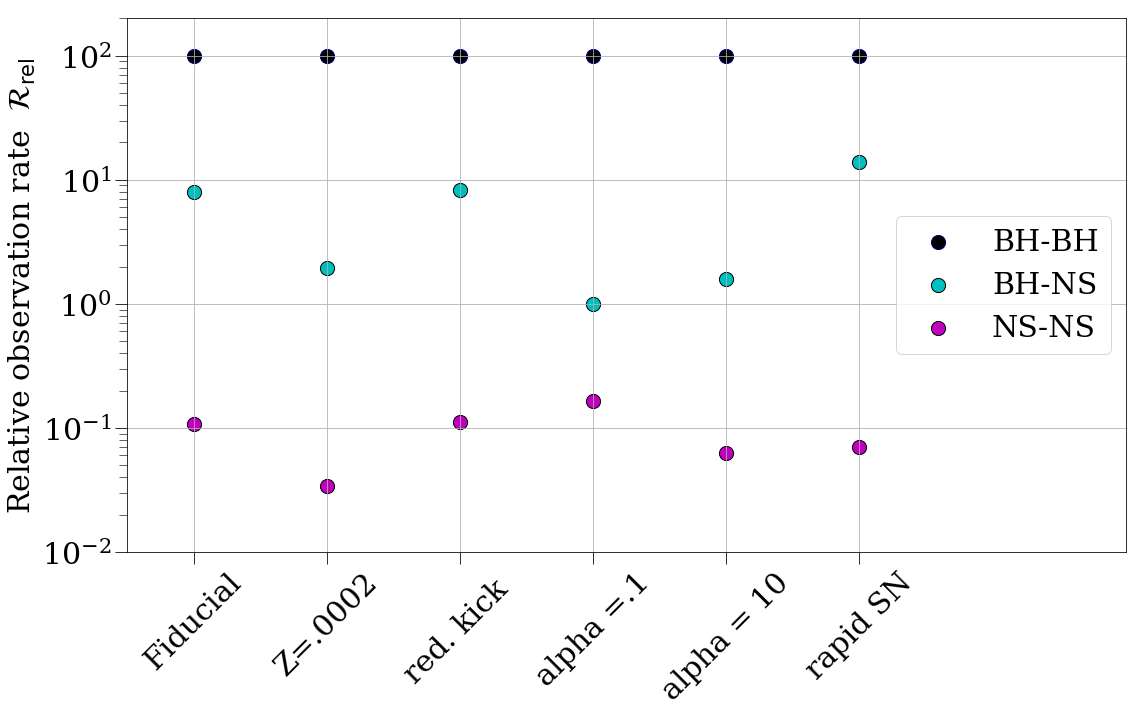

In [116]:
path = '/Volumes/TOSHIBA EXT/BHNSpaper19/'
ModelNamesList = [ 'Fiducial', 'Z=.0002', 'red. kick ', 'alpha =.1', 'alpha = 10', 'rapid SN' ]
DirNames = ['BHNSZ0_002', 'BHNSZ0_0002', 'BHNSZ0_002_REDUCEDBHkick', 'BHNSZ0_002_alpha0_1', 'BHNSZ0_002_alpha10', 'BHNSZ0_002_RAPID' ]


box = COMPASbox = [5, 150, 0, 1, 0.01, 1000, 0.1] 



axarr1 = PlotRates(COMPASbox = box, pathname = path, directory_names = DirNames, names = ModelNamesList, \
          LIGOweighted = True, whichPlot = 'relative', ylabel = r'Relative observation rate $ \ \mathcal{R}_{\rm{rel}}   $')

plt.savefig(loc_images + 'relativerates_observed.png', dpi = 300)
plt.savefig(loc_images + 'Rrelativerates_observed.pdf')



------------ BHNSZ0_002------------
rate in COMPAS box =  5516.489903364709 out of  977031 binaries (weighted to traditionally)
ALL merger rate =  170.65415350077282 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  3870.445734809716 out of  977031 binaries (weighted to traditionally)
BBH merger rate =  119.73331812712301 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  1000.3715532320093 out of  977031 binaries (weighted to traditionally)
BHNS merger rate =  30.946772964985392 mergers per Myr per MWEG (milky way equivalent galaxy)

rate in COMPAS box =  645.6726153229827 out of  977031 binaries (weighted to traditionally)
BNS merger rate =  19.974062408664395 mergers per Myr per MWEG (milky way equivalent galaxy)

------------ BHNSZ0_0002------------
rate in COMPAS box =  6837.765138538841 out of  1000015 binaries (weighted to traditionally)
ALL merger rate =  211.5281713545256 mergers per Myr per MWEG (milky way equivalent gala

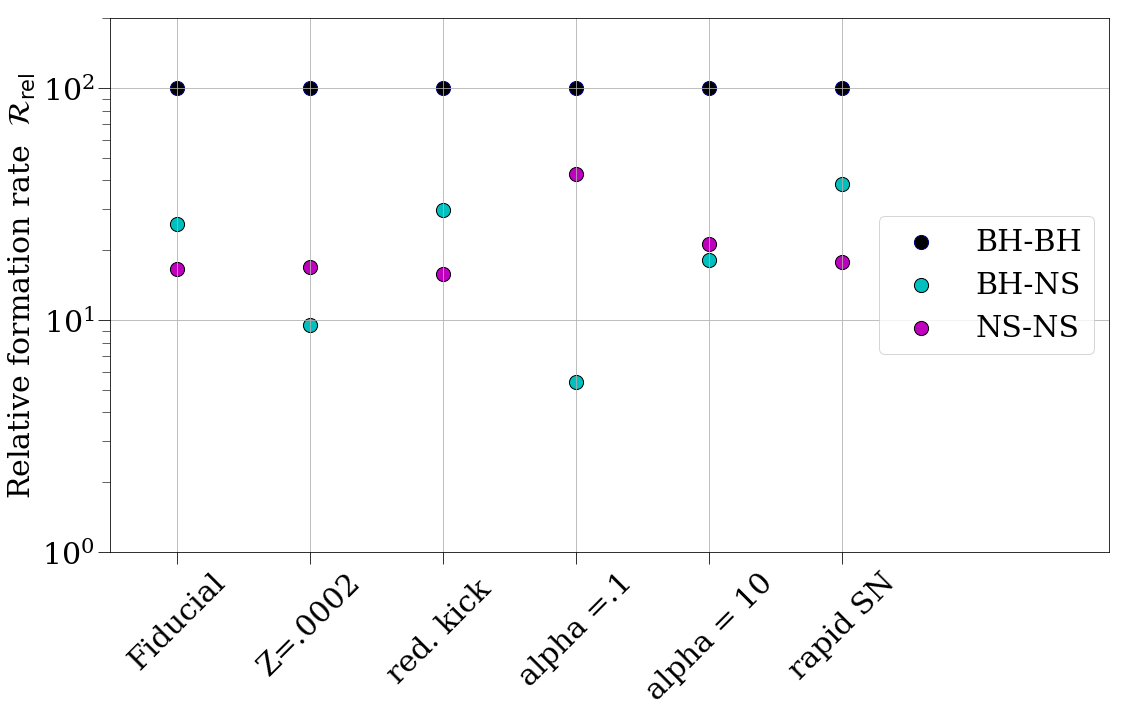

In [123]:
path = '/Volumes/TOSHIBA EXT/BHNSpaper19/'
ModelNamesList = [ 'Fiducial', 'Z=.0002', 'red. kick ', 'alpha =.1', 'alpha = 10', 'rapid SN' ]
DirNames = ['BHNSZ0_002', 'BHNSZ0_0002', 'BHNSZ0_002_REDUCEDBHkick', 'BHNSZ0_002_alpha0_1', 'BHNSZ0_002_alpha10', 'BHNSZ0_002_RAPID' ]


box = COMPASbox = [5, 150, 0, 1, 0.01, 1000, 0.1] 



axarr1 = PlotRates(COMPASbox = box, pathname = path, directory_names = DirNames, names = ModelNamesList, \
          LIGOweighted = False, whichPlot = 'relative', ylabel = r'Relative formation rate $ \ \mathcal{R}_{\rm{rel}}   $')

axarr1.set_ylim(1E0, 2E2)

plt.savefig(loc_images + 'relativerates_formation.png', dpi = 300)
plt.savefig(loc_images + 'Rrelativerates_formation.pdf')


